In [52]:
import numpy as np
import pandas as pd

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, column_or_1d
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from tscv import GapKFold

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

Test some models on multiplicative decomposition

In [2]:
filepath = '../../../data/intermediate/experimentation_train_sets/'

filename = 'train_b_1176_m_0_sm_mult_t_20200125_173449.csv'

df_features = pd.read_csv(filepath + filename, parse_dates=['timestamp'], index_col=['timestamp'])
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8512 entries, 2016-01-02 00:00:00 to 2016-12-31 11:00:00
Data columns (total 12 columns):
day_of_week                     8512 non-null int64
day_hour                        8512 non-null int64
dew_temperature_ma_24H          8512 non-null float64
air_temperature                 8512 non-null float64
wind_speed_ma_24H               8512 non-null float64
precip_depth_1_hr_ma_24H        8512 non-null float64
sea_level_pressure_shift_10H    8512 non-null float64
meter_reading                   8512 non-null float64
meter_reading_trend             8512 non-null float64
meter_reading_seasonal          8512 non-null float64
meter_reading_deseasoned        8512 non-null float64
meter_reading_resid             8512 non-null float64
dtypes: float64(10), int64(2)
memory usage: 864.5 KB


In [3]:
df_features.head()

,day_of_week,day_hour,dew_temperature_ma_24H,air_temperature,wind_speed_ma_24H,precip_depth_1_hr_ma_24H,sea_level_pressure_shift_10H,meter_reading,meter_reading_trend,meter_reading_seasonal,meter_reading_deseasoned,meter_reading_resid
timestamp,,,,,,,,,,,,
2016-01-02 00:00:00,5,0,-10.120833,-3.3,4.737500,-0.208333,1019.4,73.866,82.076000,0.768510,96.115879,1.171059
2016-01-02 01:00:00,5,1,-9.979167,-3.9,4.779167,-0.166667,1018.9,69.788,82.069396,0.720307,96.886528,1.180544
2016-01-02 02:00:00,5,2,-9.887500,-5.0,4.862500,-0.125000,1017.9,68.563,82.132312,0.693736,98.831493,1.203320
2016-01-02 03:00:00,5,3,-9.816667,-5.6,4.883333,-0.083333,1017.4,69.133,81.996854,0.684146,101.050022,1.232365
2016-01-02 04:00:00,5,4,-9.766667,-6.1,4.862500,-0.083333,1017.1,69.085,81.552562,0.681073,101.435502,1.243805


In [39]:
target_variables = set(['meter_reading', 'meter_reading_trend', 'meter_reading_deseasoned'])
others = set(['meter_reading_resid'])
features_variables = set(df_features.columns.to_list())-target_variables
meteorological_variables = features_variables - set(['day_hour']) - others
print(meteorological_variables)

{'dew_temperature_ma_24H', 'sea_level_pressure_shift_10H', 'air_temperature', 'day_of_week', 'meter_reading_seasonal', 'wind_speed_ma_24H', 'precip_depth_1_hr_ma_24H'}


In [40]:
#y_meter_trend = df_features['meter_reading']
#y_meter_seasonal = df_features['meter_reading_seasonal']
#y_meter_deseasoned = df_features['meter_reading_deseasoned']
Ys_meter = df_features[target_variables]

X_meter = df_features.loc[:, meteorological_variables.union(others)]
X_meter_with_day_hour = df_features.loc[:, meteorological_variables.union(set(['day_hour']))]
print('X_meter.shape = {}, Ys_meter.shape = {}'.format(X_meter.shape, Ys_meter.shape))

X_meter.shape = (8512, 8), Ys_meter.shape = (8512, 3)


In [42]:
X_meter.columns

Index(['dew_temperature_ma_24H', 'meter_reading_resid', 'day_of_week',
       'sea_level_pressure_shift_10H', 'meter_reading_seasonal',
       'wind_speed_ma_24H', 'air_temperature', 'precip_depth_1_hr_ma_24H'],
      dtype='object')

In [43]:
# GapKFold
# gap ~ two weeks, train = 1 month (12 folds)

gap = 24*7*2
gap_kf = GapKFold(n_splits=12, gap_before=gap, gap_after=gap)

Let's build a mean value estimator.

From https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/_template.py

check_array and check_X_y

https://github.com/scikit-learn/scikit-learn/blob/e5698bde9/sklearn/utils/validation.py#L904

In [13]:
# Actually we don't need that because it already exists in sklearn, under the name 'dummyRegressor'
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html

In [15]:
cross_val_score(
    estimator=DummyRegressor(strategy="mean"),
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.10972135653366528

In [16]:
cross_val_score(
    estimator=DummyRegressor(strategy="median"),
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.10826417581945569

In [17]:
# Now let's take the mean by hour

In [18]:
class MeanByCatEstimator(BaseEstimator):
    """ A template estimator to be used as a reference implementation.
    For more information regarding how to build your own estimator, read more
    in the :ref:`User Guide <user_guide>`.
    Parameters
    ----------
    demo_param : str, default='demo_param'
        A parameter used for demonstation of how to pass and store paramters.
    """
    def __init__(self, cat_column_idx=0, verbose=False):
        self.verbose = verbose
        self.cat_column_idx= cat_column_idx

    def fit(self, X, y):
        """A reference implementation of a fitting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        
        X, y = check_X_y(X, y, accept_sparse=True)
        """Input validation for standard estimators.
        Checks X and y for consistent length, enforces X to be 2D and y 1D. By
        default, X is checked to be non-empty and containing only finite values.
        Standard input checks are also applied to y, such as checking that y
        does not have np.nan or np.inf targets. For multi-label y, set
        multi_output=True to allow 2D and sparse y. If the dtype of X is
        object, attempt converting to float, raising on failure.
        """
        
        if(self.cat_column_idx >= X.shape[1]):
             raise ValueError("category column index should be < X.shape[1]")
        
        categories = {}
        self.means = {}
        
        self.mean = y.mean()
        
        for x_bin in np.unique(X[:, self.cat_column_idx]):
            categories[x_bin] = []
            
        if self.verbose:    
            print('categories : {}'.format(categories.keys()))
            
        for k in range(X.shape[0]):
            categories[X[k, self.cat_column_idx]].append(y[k])
        
        for k, v in categories.items():
            self.means[k] = np.array(v).mean()
        
        self.is_fitted_ = True
        # `fit` should always return `self`
        
        if self.verbose:
            for k, v in self.means.items():
                print('({}, {})'.format(k, v))
        
        return self

    
    
    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns an array of ones.
        """
        
        
        X = check_array(X, accept_sparse=True)
        """Input validation on an array, list, sparse matrix or similar.
        By default, the input is checked to be a non-empty 2D array containing
        only finite values. If the dtype of the array is object, attempt
        converting to float, raising on failure."""
        
        check_is_fitted(self, 'is_fitted_')
        
        predictions = []
        
        for sample_cat in X[:, self.cat_column_idx]:
            cat_mean = self.means.get(sample_cat)
            if(cat_mean == None):
                predictions.append(self.mean)
            else:
                predictions.append(cat_mean)
            
        
        
        return np.array(predictions)

In [26]:
day_hour_col_idx = X_meter_with_day_hour.columns.to_list().index('day_hour')

cross_val_score(
    estimator=MeanByCatEstimator(cat_column_idx=day_hour_col_idx),
    X=X_meter_with_day_hour,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.04645937314320131

In [27]:
class MeanByMultiCatEstimator(BaseEstimator):
    """ A template estimator to be used as a reference implementation.
    For more information regarding how to build your own estimator, read more
    in the :ref:`User Guide <user_guide>`.
    Parameters
    ----------
    demo_param : str, default='demo_param'
        A parameter used for demonstation of how to pass and store paramters.
    """
    def __init__(self, cat_column_indexes=[0], verbose=False):
        self.verbose = verbose
        self.cat_column_indexes = cat_column_indexes

    def fit(self, X, y):
        """A reference implementation of a fitting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        
        X, y = check_X_y(X, y, accept_sparse=True)
        """Input validation for standard estimators.
        Checks X and y for consistent length, enforces X to be 2D and y 1D. By
        default, X is checked to be non-empty and containing only finite values.
        Standard input checks are also applied to y, such as checking that y
        does not have np.nan or np.inf targets. For multi-label y, set
        multi_output=True to allow 2D and sparse y. If the dtype of X is
        object, attempt converting to float, raising on failure.
        """
        
        
        cat_columns = []
        
        for col_idx in self.cat_column_indexes:
            if(col_idx >= X.shape[1]):
                raise ValueError("category column indexes should be < X.shape[1]")
            cat_columns.append(X[:, col_idx])
            
        cat_tuples = set(zip(*cat_columns))
        
        categories = {}
        self.means = {}
        
        self.mean = y.mean()
        
        for x_bin in cat_tuples:
            categories[x_bin] = []
            
        if self.verbose:    
            print('categories : {}'.format(categories.keys()))
            
        for k in range(X.shape[0]):
            sample_bin = tuple(X[k, self.cat_column_indexes])
            categories[sample_bin].append(y[k])
        
        for k, v in categories.items():
            self.means[k] = np.array(v).mean()
        
        self.is_fitted_ = True
        # `fit` should always return `self`
        
        if self.verbose:
            for k, v in self.means.items():
                print('({}, {})'.format(k, v))
        
        return self

    
    
    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns an array of ones.
        """
        
        
        X = check_array(X, accept_sparse=True)
        """Input validation on an array, list, sparse matrix or similar.
        By default, the input is checked to be a non-empty 2D array containing
        only finite values. If the dtype of the array is object, attempt
        converting to float, raising on failure."""
        
        check_is_fitted(self, 'is_fitted_')
        
        predictions = []
        
        
        cat_columns=[]
        for col in self.cat_column_indexes:
            cat_columns.append(X[:, col])
            
        cat_tuples = list(zip(*cat_columns))
        
        
        
        for sample_cat in cat_tuples:
            cat_mean = self.means.get(sample_cat)
            if(cat_mean == None):
                predictions.append(self.mean)
            else:
                predictions.append(cat_mean)
            
        
        
        return np.array(predictions)

In [31]:
day_hour_col_idx = X_meter_with_day_hour.columns.to_list().index('day_hour')
day_of_week_col_idx = X_meter_with_day_hour.columns.to_list().index('day_of_week')
time_col_indexes = [day_hour_col_idx, day_of_week_col_idx]

In [33]:
cross_val_score(
    estimator=MeanByMultiCatEstimator(time_col_indexes),
    X=X_meter_with_day_hour,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.02648838645731298

In [30]:
# Let's try a linear regression

In [33]:
# Try a k nearest-neighbours.
# We need to scale, so to use a scaler with cross-validation, we need to set a pipeline.

In [34]:
X_meter.head()

,wind_speed_ma_24H,air_temperature,sea_level_pressure_shift_10H,day_of_week,meter_reading_seasonal,precip_depth_1_hr_ma_24H,meter_reading_resid,dew_temperature_ma_24H
timestamp,,,,,,,,
2016-01-02 00:00:00,4.737500,-3.3,1019.4,5,-26.759415,-0.208333,18.549415,-10.120833
2016-01-02 01:00:00,4.779167,-3.9,1018.9,5,-32.469222,-0.166667,20.187826,-9.979167
2016-01-02 02:00:00,4.862500,-5.0,1017.9,5,-35.705572,-0.125000,22.136259,-9.887500
2016-01-02 03:00:00,4.883333,-5.6,1017.4,5,-36.882202,-0.083333,24.018348,-9.816667
2016-01-02 04:00:00,4.862500,-6.1,1017.1,5,-37.362799,-0.083333,24.895237,-9.766667


In [36]:

transformers = [('scaler', StandardScaler()), ('estimator', LinearRegression())]

my_first_pipe = Pipeline(transformers)




In [37]:
cross_val_score(my_first_pipe, X_meter, y_meter,  scoring='neg_mean_squared_log_error',
    cv=gap_kf)

NameError: name 'y_meter' is not defined

In [39]:
pipe = make_pipeline(StandardScaler(), KNeighborsRegressor())
cross_val_score(pipe, X_meter, y_meter, scoring='neg_mean_squared_log_error', cv=gap_kf).mean()

NameError: name 'y_meter' is not defined

In [ ]:
pipe.get_params().keys()

In [40]:
pipe = make_pipeline(StandardScaler(), KNeighborsRegressor())

knn_grid_params = {
    'kneighborsregressor__n_neighbors' : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70],
    'kneighborsregressor__p' : [1, 2, 3, 4]
}

knn_CV = GridSearchCV(
    estimator=pipe, 
    param_grid=knn_grid_params,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf
)

knn_CV.fit(X_meter, y_meter)

NameError: name 'y_meter' is not defined

In [41]:
knn_CV.cv_results_

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [42]:
print('best_params : {}'.format(knn_CV.best_params_))
print('best_score : {}'.format(knn_CV.best_score_))

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [96]:
# Build an estimator which is the multiplication of an estimator by the seasonal component.

class MultiplicativeTrendEstimator(BaseEstimator):
    """ A template estimator to be used as a reference implementation.
    For more information regarding how to build your own estimator, read more
    in the :ref:`User Guide <user_guide>`.
    Parameters
    ----------
    demo_param : str, default='demo_param'
        A parameter used for demonstation of how to pass and store paramters.
    """
    def __init__(self, trend_estimator, seasonal_component_idx, resid_idx):
        self.trend_estimator = trend_estimator
        self.seasonal_component_idx = seasonal_component_idx
        self.resid_idx = resid_idx

    def fit(self, X, y):
        """A reference implementation of a fitting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=True)
        
        self.features_idxs = list(set(range(X.shape[1])) - set([self.seasonal_component_idx, self.resid_idx]))
        
        # fit only on trend features
        X_trend = X[:, self.features_idxs]
        
        
        # Substract trend to target
        y_trend = y / X[:, self.seasonal_component_idx] / X[:, self.resid_idx]
        
        
        self.trend_estimator.fit(X_trend, y_trend)
        
        self.is_fitted_ = True
        # `fit` should always return `self`
        return self

    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns an array of ones.
        """
        
        X = check_array(X, accept_sparse=True)
        check_is_fitted(self, 'is_fitted_')
        
        # fit only on trend features
        X_trend = X[:, self.features_idxs]
        
        predicted_trend = self.trend_estimator.predict(X_trend)
        
        y_season = X[:, self.seasonal_component_idx]
            
        
            
        return np.maximum(0, predicted_trend * y_season)

In [92]:
a = np.array([[1,-2,3], [4,5,6]])
a

array([[ 1, -2,  3],
       [ 4,  5,  6]])

In [93]:
np.maximum(a,0)

array([[1, 0, 3],
       [4, 5, 6]])

In [85]:
resid_idx = X_meter.columns.to_list().index('meter_reading_resid')
seasonal_idx = X_meter_with_day_hour.columns.to_list().index('meter_reading_seasonal')

In [100]:
trendLinReg = LinearRegression()
full_est = MultiplicativeTrendEstimator(trendLinReg, seasonal_idx, resid_idx)

cross_val_score(
    estimator=full_est,
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.038786250179492075

In [106]:
trendKNN =  KNeighborsRegressor(n_neighbors=50, p=1)
full_est = MultiplicativeTrendEstimator(trendKNN, seasonal_idx, resid_idx)

cross_val_score(
    estimator=full_est,
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.08881981542770591

In [97]:
trendKNR = KNeighborsRegressor()
full_est = MultiplicativeTrendEstimator(trendKNR, seasonal_idx, resid_idx)

pipe = make_pipeline(StandardScaler(), full_est)

pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'multiplicativetrendestimator', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'multiplicativetrendestimator__resid_idx', 'multiplicativetrendestimator__seasonal_component_idx', 'multiplicativetrendestimator__trend_estimator__algorithm', 'multiplicativetrendestimator__trend_estimator__leaf_size', 'multiplicativetrendestimator__trend_estimator__metric', 'multiplicativetrendestimator__trend_estimator__metric_params', 'multiplicativetrendestimator__trend_estimator__n_jobs', 'multiplicativetrendestimator__trend_estimator__n_neighbors', 'multiplicativetrendestimator__trend_estimator__p', 'multiplicativetrendestimator__trend_estimator__weights', 'multiplicativetrendestimator__trend_estimator'])

In [104]:
trendKNR = KNeighborsRegressor()
full_est = MultiplicativeTrendEstimator(trendKNR, seasonal_idx, resid_idx)

pipe = make_pipeline(StandardScaler(), full_est)

knn_grid_params = {
    'multiplicativetrendestimator__trend_estimator__n_neighbors' : [20, 50, 70, 80],
    'multiplicativetrendestimator__trend_estimator__p' : [1]
}

knn_CV = GridSearchCV(
    estimator=pipe, 
    param_grid=knn_grid_params,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf
)

knn_CV.fit(X_meter, Ys_meter['meter_reading'])

GridSearchCV(cv=GapKFold(gap_after=336, gap_before=336, n_splits=12),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('multiplicativetrendestimator',
                                        MultiplicativeTrendEstimator(resid_idx=1,
                                                                     seasonal_component_idx=3,
                                                                     trend_estimator=KNeighborsRegressor(algor...
                                                                                                         metric_params=None,
                                                                                    

In [105]:
print('best_params : {}'.format(knn_CV.best_params_))
print('best_score : {}'.format(knn_CV.best_score_))

best_params : {'multiplicativetrendestimator__trend_estimator__n_neighbors': 80, 'multiplicativetrendestimator__trend_estimator__p': 1}
best_score : -13.874509217175888


In [82]:
trendRFR = RandomForestRegressor()
full_est = MultiplicativeTrendEstimator(trendRFR, seasonal_idx, resid_idx)

pipe = make_pipeline(StandardScaler(), full_est)
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'multiplicativetrendestimator', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'multiplicativetrendestimator__resid_idx', 'multiplicativetrendestimator__seasonal_component_idx', 'multiplicativetrendestimator__trend_estimator__bootstrap', 'multiplicativetrendestimator__trend_estimator__criterion', 'multiplicativetrendestimator__trend_estimator__max_depth', 'multiplicativetrendestimator__trend_estimator__max_features', 'multiplicativetrendestimator__trend_estimator__max_leaf_nodes', 'multiplicativetrendestimator__trend_estimator__min_impurity_decrease', 'multiplicativetrendestimator__trend_estimator__min_impurity_split', 'multiplicativetrendestimator__trend_estimator__min_samples_leaf', 'multiplicativetrendestimator__trend_estimator__min_samples_split', 'multiplicativetrendestimator__trend_estimator__min_weight_fraction_leaf', 'multiplicativetrendestimator__trend_estimator__n_estimators', 'multip

In [107]:
trendRFR = RandomForestRegressor()
full_est = MultiplicativeTrendEstimator(trendRFR, seasonal_idx, resid_idx)

pipe = make_pipeline(StandardScaler(), full_est)

knn_grid_params = {
    'multiplicativetrendestimator__trend_estimator__n_estimators' : [50, 100],
    'multiplicativetrendestimator__trend_estimator__max_features' : ['auto', 'sqrt']
    
}

knn_CV = GridSearchCV(
    estimator=pipe, 
    param_grid=knn_grid_params,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf
)

knn_CV.fit(X_meter, Ys_meter['meter_reading'])

GridSearchCV(cv=GapKFold(gap_after=336, gap_before=336, n_splits=12),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('multiplicativetrendestimator',
                                        MultiplicativeTrendEstimator(resid_idx=1,
                                                                     seasonal_component_idx=3,
                                                                     trend_estimator=RandomForestRegressor(boo...
                                                                                                           random_state=None,
                                                                                   

In [109]:
print('best_params : {}'.format(knn_CV.best_params_))
print('best_score : {}'.format(knn_CV.best_score_))

best_params : {'multiplicativetrendestimator__trend_estimator__max_features': 'auto', 'multiplicativetrendestimator__trend_estimator__n_estimators': 50}
best_score : -14.25269726700538


In [111]:
trendRFR = RandomForestRegressor(n_estimators=50, max_features='sqrt')
full_est = MultiplicativeTrendEstimator(trendRFR, seasonal_idx, resid_idx)

In [112]:
cross_val_score(
    estimator=full_est,
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.03259490855077297

In [113]:
preds = cross_val_predict(
    estimator=full_est,
    X=X_meter,
    y=Ys_meter['meter_reading'],
    cv=gap_kf)

In [131]:
day_hour_col_idx = X_meter_with_day_hour.columns.to_list().index('day_hour')
day_of_week_col_idx = X_meter_with_day_hour.columns.to_list().index('day_of_week')
time_col_indexes = [day_hour_col_idx, day_of_week_col_idx]

benchmark_preds = cross_val_predict(
    estimator=MeanByMultiCatEstimator(time_col_indexes),
    X=X_meter_with_day_hour,
    y=Ys_meter['meter_reading'],
    cv=gap_kf)

In [132]:
benchmark_preds

array([ 79.27184444,  76.27879545,  73.53926667, ...,  94.6694    ,
       104.11602174, 106.4836087 ])

In [133]:
X_meter_w_temperature_bins

In [135]:
preds_df_melt = pd.melt(preds_df.reset_index(inplace=False), id_vars='timestamp', 
                                 var_name='component', value_name = 'reading')
preds_df_melt.head()

,timestamp,component,reading
0,2016-01-02 00:00:00,predictions,77.608854
1,2016-01-02 01:00:00,predictions,74.597352
2,2016-01-02 02:00:00,predictions,72.434688
3,2016-01-02 03:00:00,predictions,72.174213
4,2016-01-02 04:00:00,predictions,72.004339


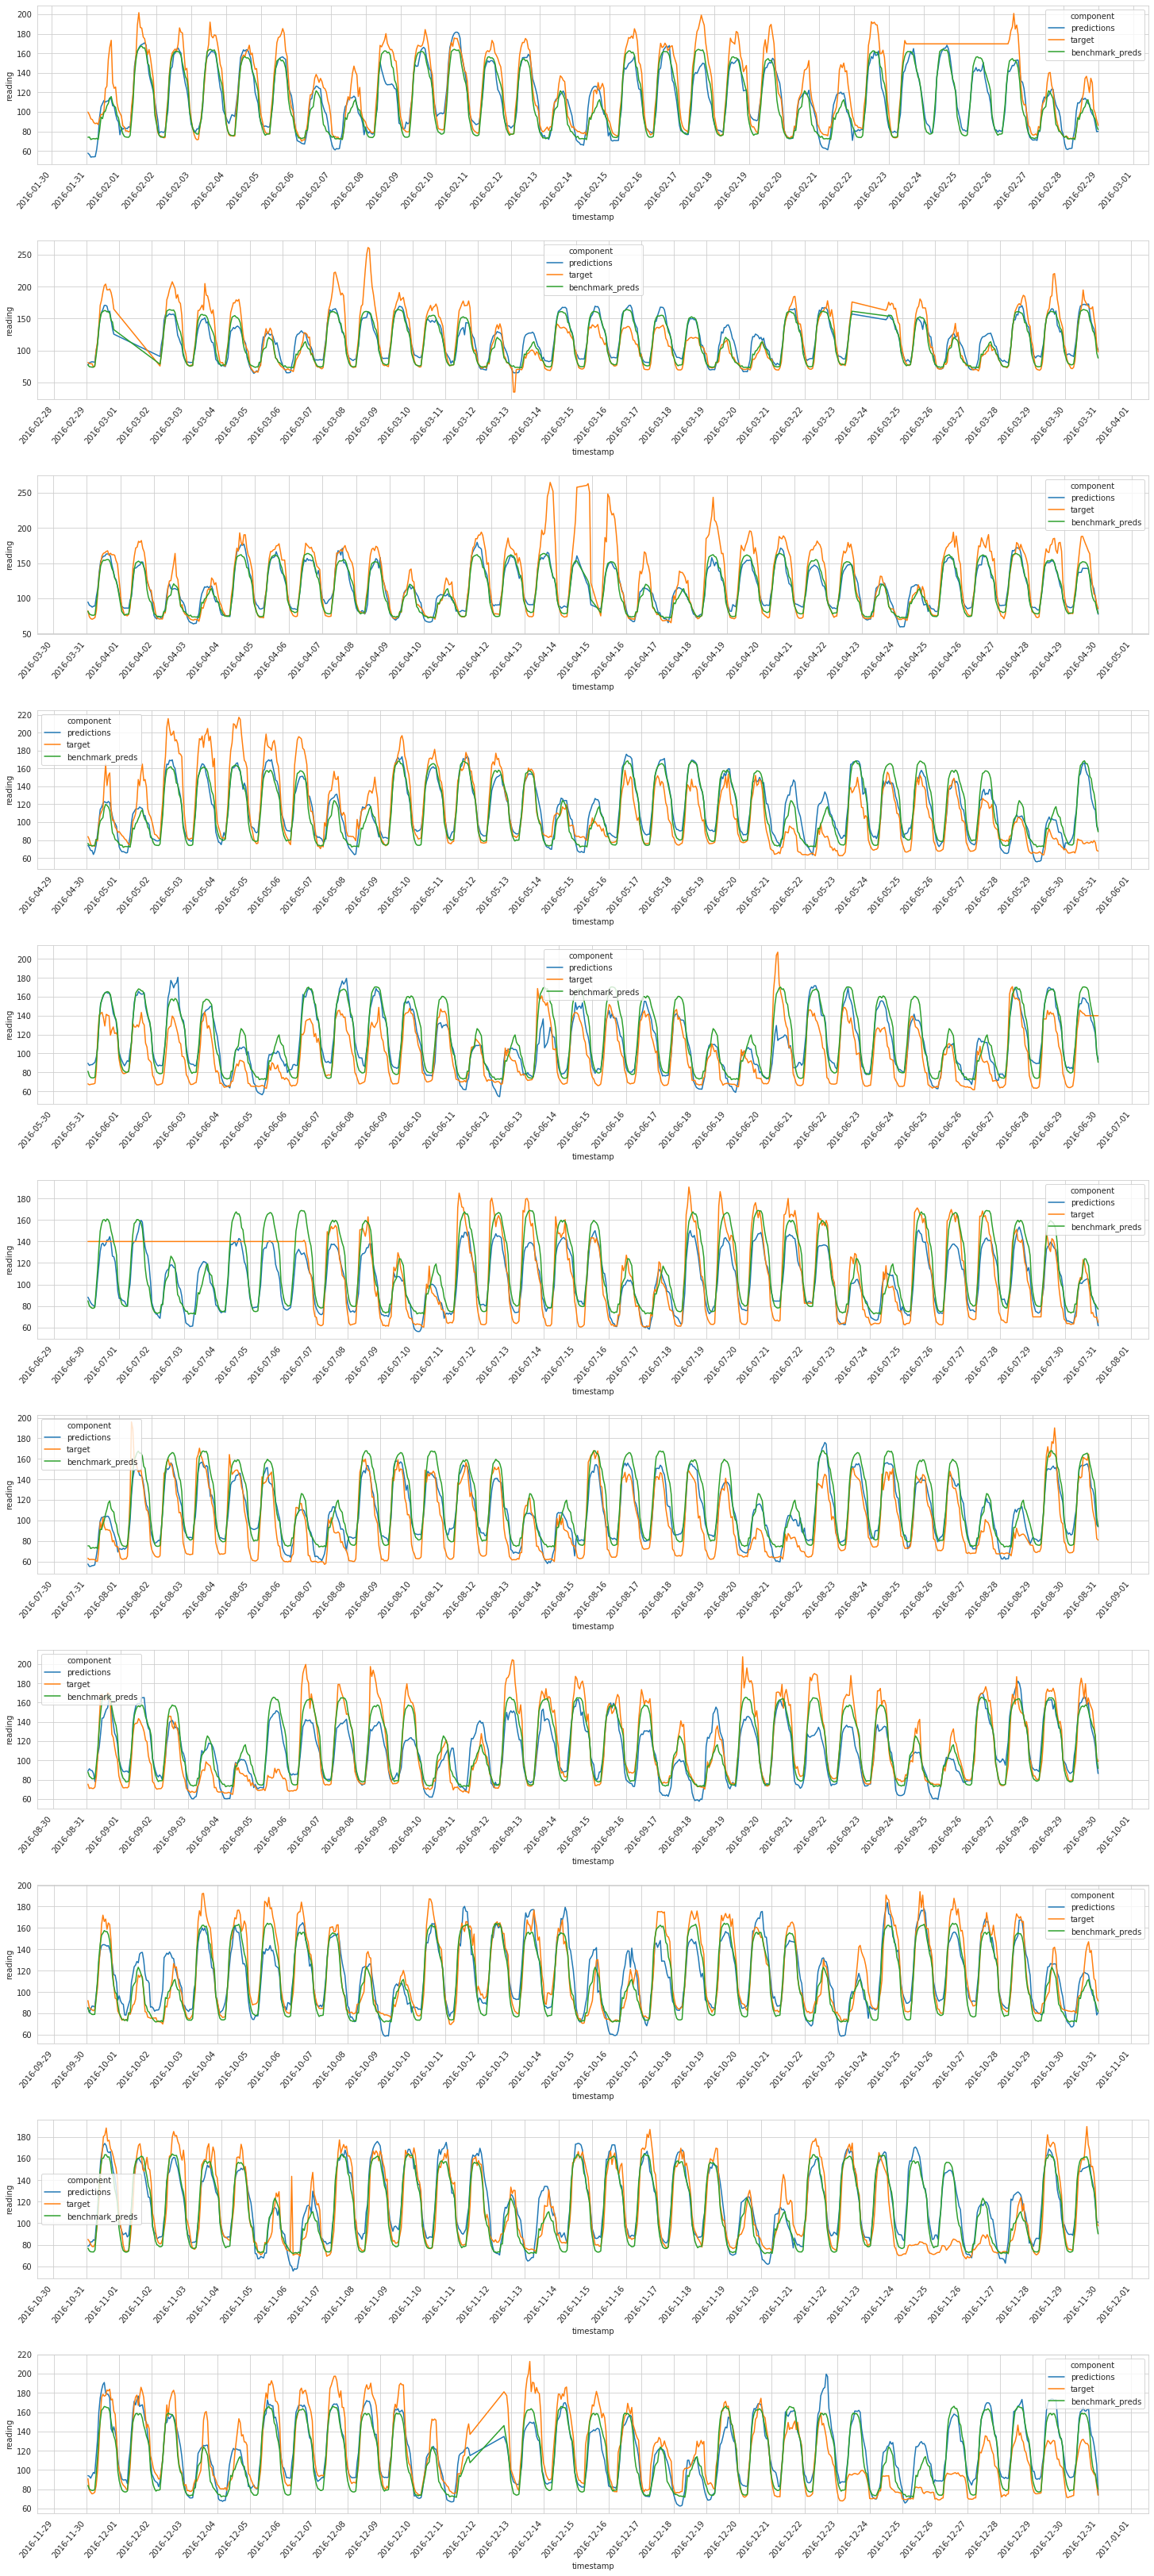

In [136]:
# Plot month by month

date_range = pd.date_range(start=X_meter.index.min()-pd.Timedelta('1 days'), 
                           end=X_meter.index.max(), freq='1M')

fig = plt.figure(figsize=(20, 4*date_range.shape[0]))

restrict_df_to_dates = lambda df, d1, d2 : df[(df['timestamp'] > d1) & (df['timestamp'] <= d2)]


with sns.axes_style("whitegrid"):
    for i in range(date_range.shape[0]-1) :
        plt.subplot(12,1,i+1)
        start_date = date_range[i]
        end_date = date_range[i+1]
        data = restrict_df_to_dates(preds_df_melt, start_date, end_date)
        ax = sns.lineplot(x="timestamp", y="reading", hue="component", data=data)
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=50, horizontalalignment='right')
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)    

In [119]:
X_meter.columns

Index(['dew_temperature_ma_24H', 'meter_reading_resid', 'day_of_week',
       'sea_level_pressure_shift_10H', 'meter_reading_seasonal',
       'wind_speed_ma_24H', 'air_temperature', 'precip_depth_1_hr_ma_24H'],
      dtype='object')

In [120]:
preds_df_2 = pd.DataFrame(index=X_meter.index)
preds_df_2['trend_predictions'] = preds / X_meter['meter_reading_seasonal']
preds_df_2['meter_reading'] = Ys_meter['meter_reading']
preds_df_2['trend_target'] = Ys_meter['meter_reading_trend']
preds_df_2['meter_deseasoned'] = Ys_meter['meter_reading_deseasoned']

In [121]:
preds_df_2_melt = pd.melt(preds_df_2.reset_index(inplace=False), id_vars='timestamp', 
                                 var_name='component', value_name = 'reading')
preds_df_2_melt.head()

,timestamp,component,reading
0,2016-01-02 00:00:00,trend_predictions,100.986153
1,2016-01-02 01:00:00,trend_predictions,103.563341
2,2016-01-02 02:00:00,trend_predictions,104.412413
3,2016-01-02 03:00:00,trend_predictions,105.495289
4,2016-01-02 04:00:00,trend_predictions,105.721883


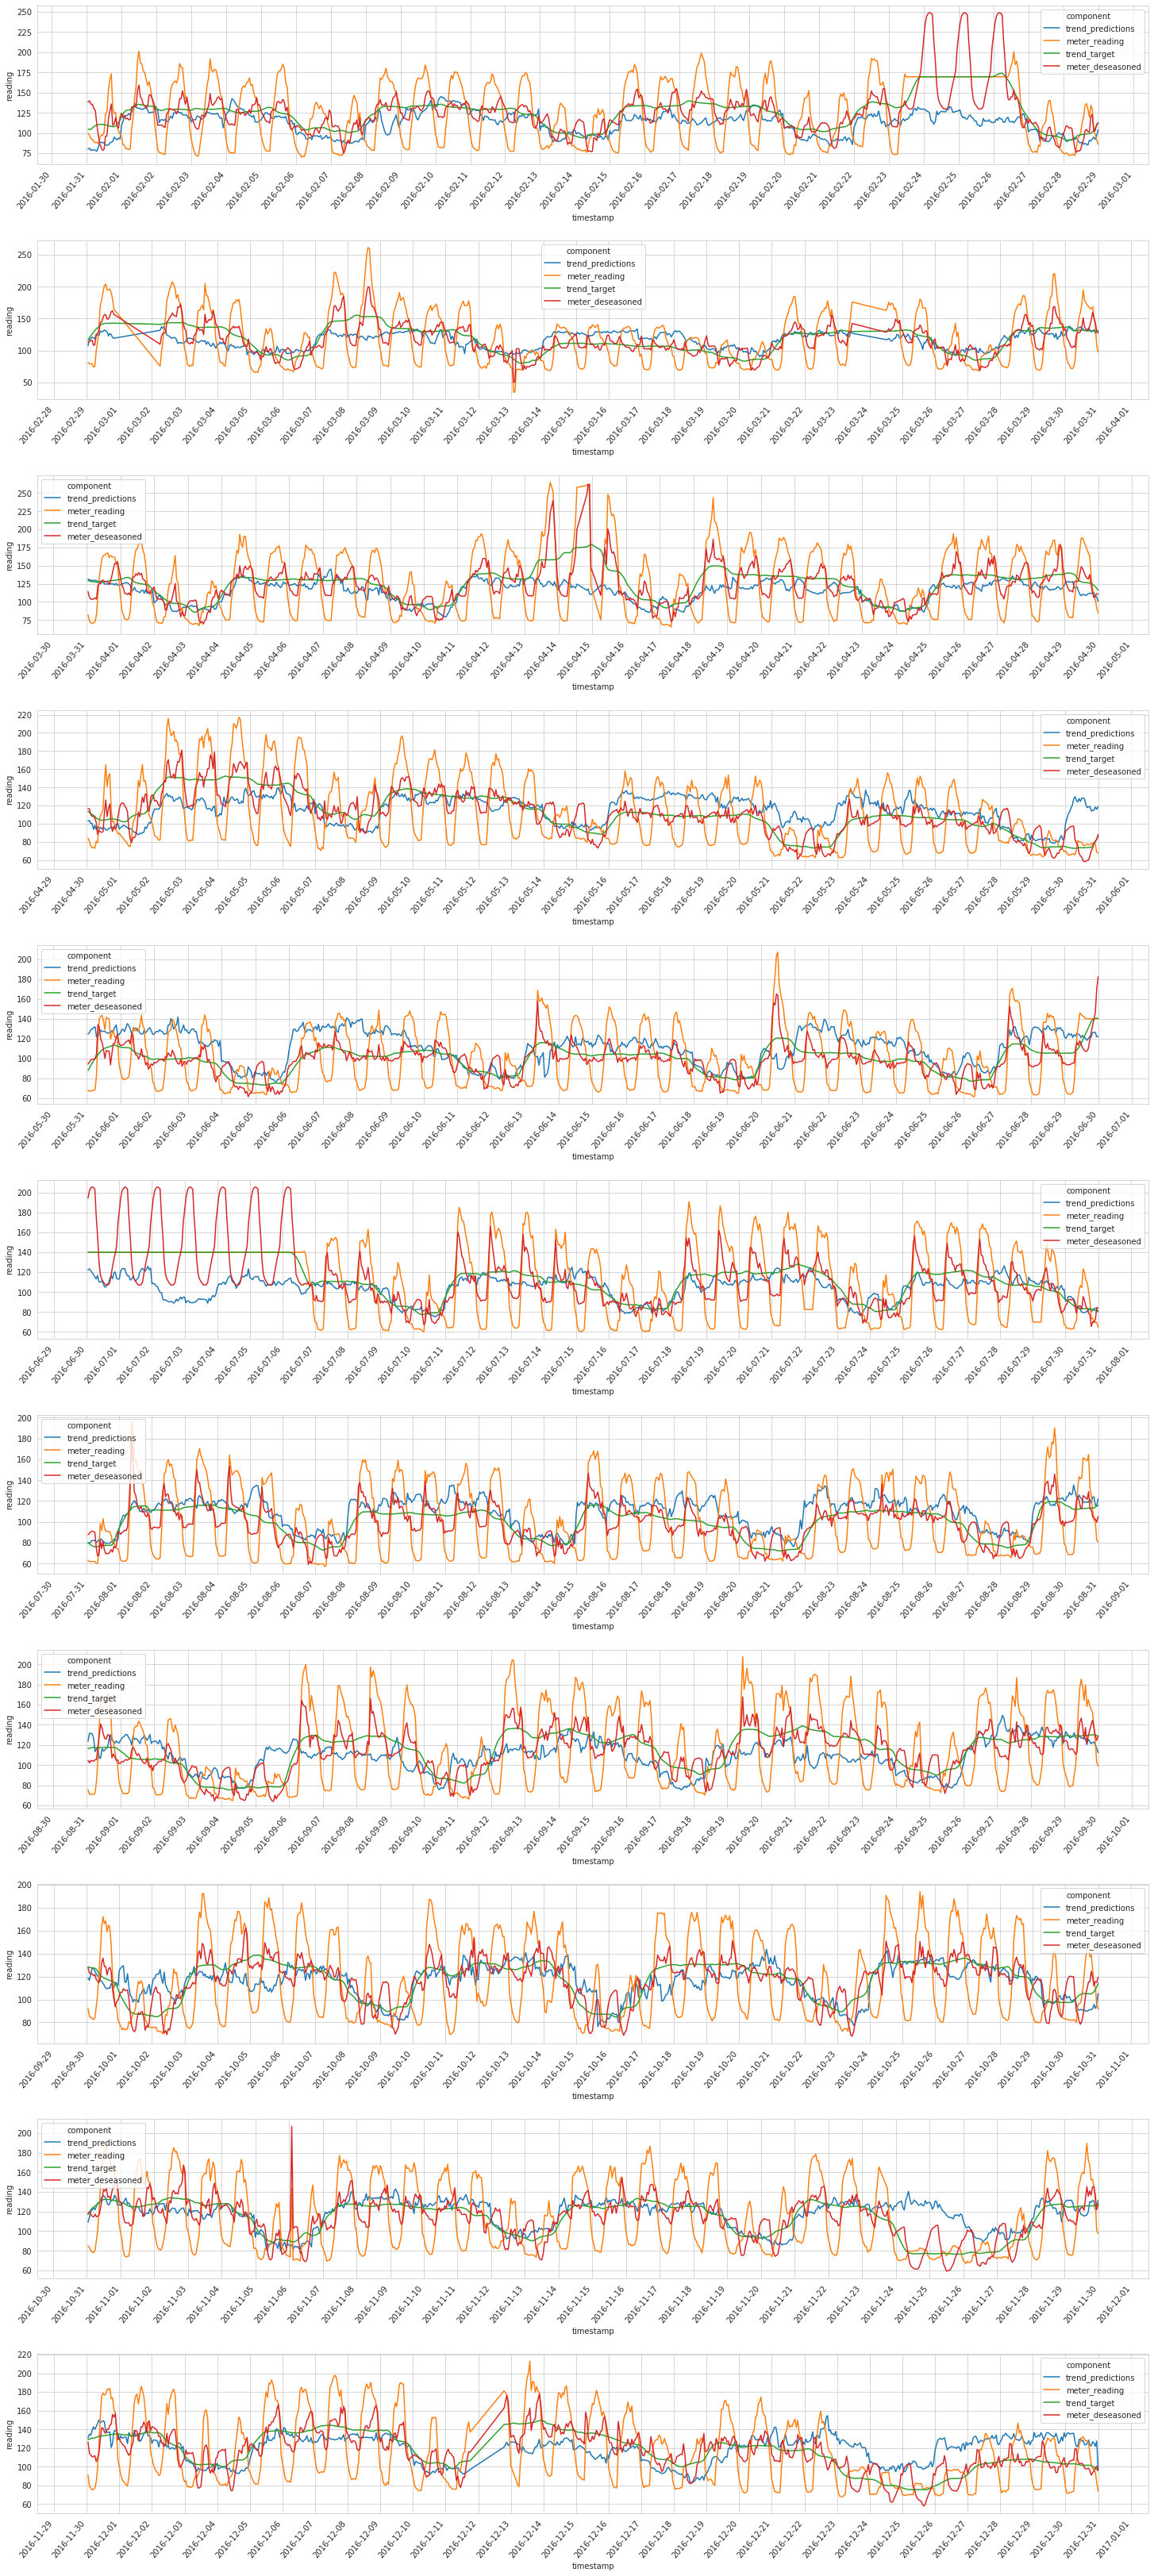

In [122]:
# Plot month by month

date_range = pd.date_range(start=X_meter.index.min()-pd.Timedelta('1 days'), 
                           end=X_meter.index.max(), freq='1M')

fig = plt.figure(figsize=(20, 4*date_range.shape[0]))

restrict_df_to_dates = lambda df, d1, d2 : df[(df['timestamp'] > d1) & (df['timestamp'] <= d2)]


with sns.axes_style("whitegrid"):
    for i in range(date_range.shape[0]-1) :
        plt.subplot(12,1,i+1)
        start_date = date_range[i]
        end_date = date_range[i+1]
        data = restrict_df_to_dates(preds_df_2_melt, start_date, end_date)
        ax = sns.lineplot(x="timestamp", y="reading", hue="component", data=data)
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=50, horizontalalignment='right')
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)    